Thiết lập môi trường & import thư viện 

In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
import zipfile
from PIL import Image
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

# Thiết lập seed
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.15.0


Tải & Chuẩn bị dữ liệu VinaFood21

Dữ liệu đã được giải nén trước đó.
✓ Tìm thấy thư mục train: VinaFood21_data\VinaFood21\train
✓ Tìm thấy thư mục test: VinaFood21_data\VinaFood21\test
Found 8042 images belonging to 21 classes.
Found 2002 images belonging to 21 classes.
Found 6682 images belonging to 21 classes.

THÔNG TIN DATASET
Số lượng lớp: 21
Tên các lớp: ['banh-can', 'banh-hoi', 'banh-mi-chao', 'banh-tet', 'banh-trang-tron', 'banh-u', 'banh-uot', 'bap-nuong', 'bo-kho', 'bo-la-lot', 'bot-chien', 'ca-ri', 'canh-kho-qua', 'canh-khoai-mo', 'ga-nuong', 'goi-ga', 'ha-cao', 'hoanh-thanh-nuoc', 'pha-lau', 'tau-hu', 'thit-kho-trung']
Số ảnh training: 8042
Số ảnh validation: 2002
Số ảnh test: 6682

PHÂN BỐ DỮ LIỆU THEO CLASS

Class                Train      Test      
----------------------------------------
banh-can             363        241       
banh-hoi             910        607       
banh-mi-chao         434        289       
banh-tet             548        364       
banh-trang-tron      465        309       
ban

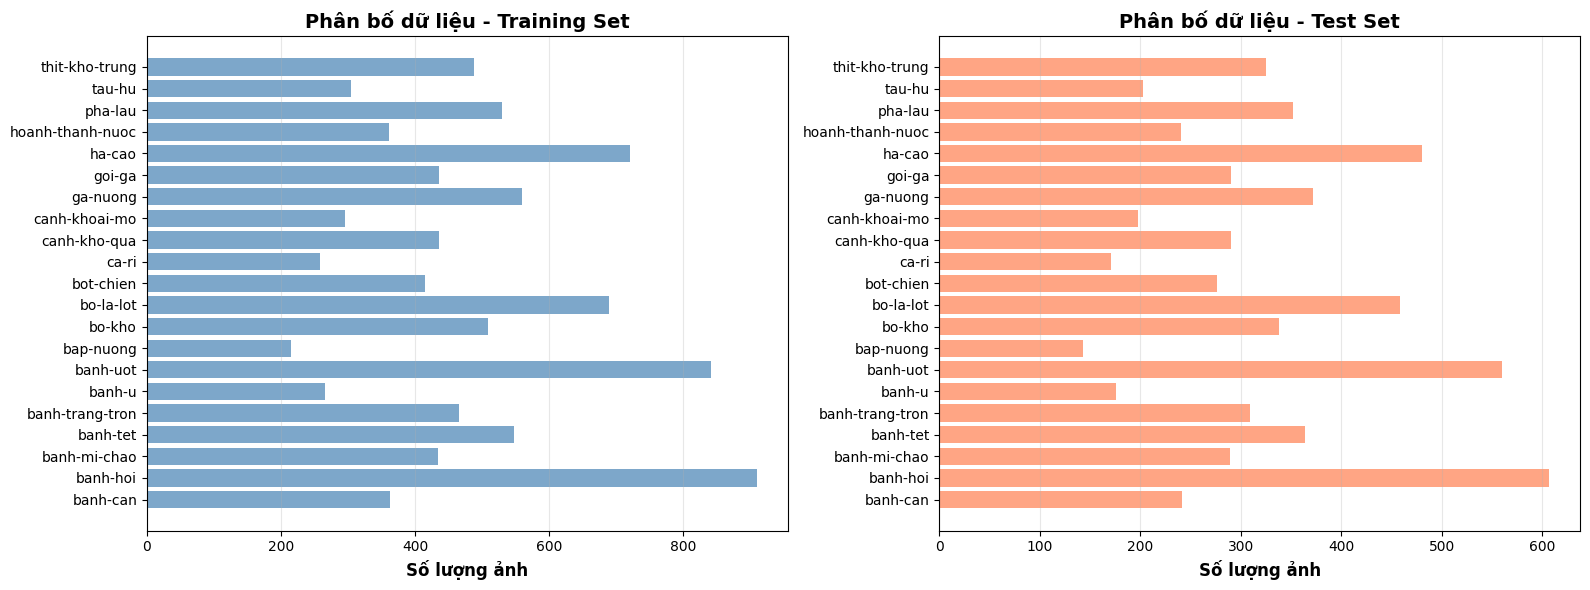


✓ Đã lưu biểu đồ phân bố dữ liệu vào 'data_distribution.png'

KIỂM TRA KÍCH THƯỚC ẢNH GỐC
Kiểm tra 10 ảnh mẫu từ class 'banh-can':
  Ảnh 1: 1080x1080 pixels
  Ảnh 2: 1080x1080 pixels
  Ảnh 3: 1080x1080 pixels
  Ảnh 4: 1080x1080 pixels
  Ảnh 5: 1080x864 pixels
  Ảnh 6: 1080x1080 pixels
  Ảnh 7: 1080x1080 pixels
  Ảnh 8: 1080x1080 pixels
  Ảnh 9: 936x1170 pixels
  Ảnh 10: 1080x1080 pixels

Kích thước trung bình: 1066x1067 pixels
Kích thước sau resize: 64x64 pixels (cho LeNet)


In [22]:
# Đường dẫn tới file zip
zip_path = 'VinaFood21.zip'
extract_path = 'VinaFood21_data'

# Giải nén file zip (nếu chưa giải nén)
if not os.path.exists(extract_path):
    print("Đang giải nén dữ liệu...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Hoàn tất giải nén!")
else:
    print("Dữ liệu đã được giải nén trước đó.")

# Tìm thư mục chứa dữ liệu train/test
# Đường dẫn: VinaFood21_data/VinaFood21/train và VinaFood21_data/VinaFood21/test
data_dir = os.path.join(extract_path, 'VinaFood21')

# Kiểm tra đường dẫn có đúng không
train_path = os.path.join(data_dir, 'train')
test_path = os.path.join(data_dir, 'test')

if not os.path.exists(train_path):
    print(f"⚠ CẢNH BÁO: Không tìm thấy thư mục train tại {train_path}")
    print("Vui lòng kiểm tra lại cấu trúc thư mục!")
else:
    print(f"✓ Tìm thấy thư mục train: {train_path}")
    
if not os.path.exists(test_path):
    print(f"⚠ CẢNH BÁO: Không tìm thấy thư mục test tại {test_path}")
else:
    print(f"✓ Tìm thấy thư mục test: {test_path}")

# Thiết lập thông số ảnh
img_height = 64
img_width = 64
batch_size = 32

# Tạo data generators với augmentation cho training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    validation_split=0.2  # Chia 20% làm validation
)

# Generator riêng cho test (chỉ rescale, không augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load dữ liệu training
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42  # Thêm seed cho reproducibility
)

# Load dữ liệu validation
validation_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42  # Cùng seed để đảm bảo split nhất quán
)

# Load dữ liệu test
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# In thông tin về dataset
print(f"\n{'='*70}")
print(f"THÔNG TIN DATASET")
print(f"{'='*70}")
print(f"Số lượng lớp: {train_generator.num_classes}")
print(f"Tên các lớp: {list(train_generator.class_indices.keys())}")
print(f"Số ảnh training: {train_generator.samples}")
print(f"Số ảnh validation: {validation_generator.samples}")
print(f"Số ảnh test: {test_generator.samples}")

# Kiểm tra kích thước ảnh và số lượng ảnh mỗi class
print(f"\n{'='*70}")
print(f"PHÂN BỐ DỮ LIỆU THEO CLASS")
print(f"{'='*70}")

# Đếm số lượng ảnh trong mỗi class (training set)
class_counts_train = {}
for class_name in train_generator.class_indices.keys():
    class_path = os.path.join(train_path, class_name)
    if os.path.exists(class_path):
        num_images = len([f for f in os.listdir(class_path) 
                         if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        class_counts_train[class_name] = num_images

# Đếm số lượng ảnh trong mỗi class (test set)
class_counts_test = {}
for class_name in test_generator.class_indices.keys():
    class_path = os.path.join(test_path, class_name)
    if os.path.exists(class_path):
        num_images = len([f for f in os.listdir(class_path) 
                         if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        class_counts_test[class_name] = num_images

# Hiển thị bảng phân bố
print(f"\n{'Class':<20} {'Train':<10} {'Test':<10}")
print(f"{'-'*40}")
for class_name in sorted(train_generator.class_indices.keys()):
    train_count = class_counts_train.get(class_name, 0)
    test_count = class_counts_test.get(class_name, 0)
    print(f"{class_name:<20} {train_count:<10} {test_count:<10}")

print(f"{'-'*40}")
print(f"{'TỔNG':<20} {sum(class_counts_train.values()):<10} {sum(class_counts_test.values()):<10}")

# Vẽ biểu đồ phân bố
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Biểu đồ training set
axes[0].barh(list(class_counts_train.keys()), list(class_counts_train.values()), 
             color='steelblue', alpha=0.7)
axes[0].set_xlabel('Số lượng ảnh', fontsize=12, fontweight='bold')
axes[0].set_title('Phân bố dữ liệu - Training Set', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Biểu đồ test set
axes[1].barh(list(class_counts_test.keys()), list(class_counts_test.values()), 
             color='coral', alpha=0.7)
axes[1].set_xlabel('Số lượng ảnh', fontsize=12, fontweight='bold')
axes[1].set_title('Phân bố dữ liệu - Test Set', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('data_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print("\n✓ Đã lưu biểu đồ phân bố dữ liệu vào 'data_distribution.png'")

# Kiểm tra kích thước ảnh gốc
print(f"\n{'='*70}")
print(f"KIỂM TRA KÍCH THƯỚC ẢNH GỐC")
print(f"{'='*70}")

sample_sizes = []
sample_class = list(train_generator.class_indices.keys())[0]
sample_class_path = os.path.join(train_path, sample_class)
sample_files = [f for f in os.listdir(sample_class_path) 
                if f.lower().endswith(('.png', '.jpg', '.jpeg'))][:10]

for img_file in sample_files:
    img_path = os.path.join(sample_class_path, img_file)
    img = Image.open(img_path)
    sample_sizes.append(img.size)

print(f"Kiểm tra 10 ảnh mẫu từ class '{sample_class}':")
for i, size in enumerate(sample_sizes, 1):
    print(f"  Ảnh {i}: {size[0]}x{size[1]} pixels")

# Tính kích thước trung bình
avg_width = sum([s[0] for s in sample_sizes]) / len(sample_sizes)
avg_height = sum([s[1] for s in sample_sizes]) / len(sample_sizes)
print(f"\nKích thước trung bình: {avg_width:.0f}x{avg_height:.0f} pixels")
print(f"Kích thước sau resize: {img_width}x{img_height} pixels (cho LeNet)")


Hiển thị vài mẫu ảnh


HIỂN THỊ MẪU ẢNH TỪ TẬP TRAINING


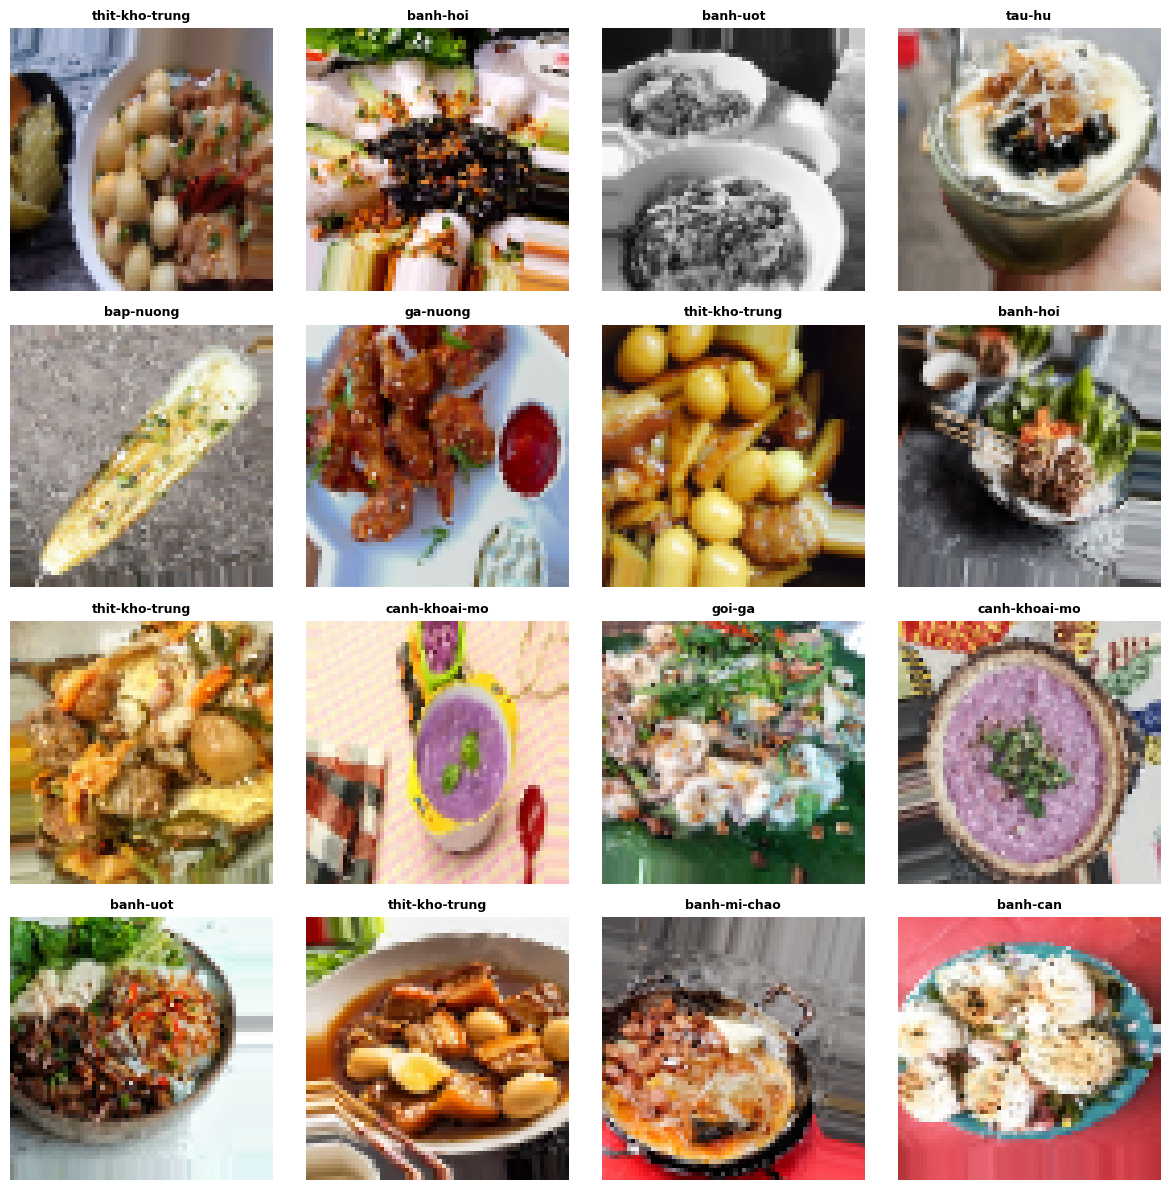


✓ Đã lưu ảnh mẫu vào 'sample_images.png'


In [23]:
# Lấy danh sách tên các class
class_names = list(train_generator.class_indices.keys())

# Lấy một batch ảnh để hiển thị
sample_batch_x, sample_batch_y = next(train_generator)
train_generator.reset()  # Reset về đầu

print(f"\n{'='*70}")
print(f"HIỂN THỊ MẪU ẢNH TỪ TẬP TRAINING")
print(f"{'='*70}")

plt.figure(figsize=(12, 12))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(sample_batch_x[i])
    
    # Lấy label từ one-hot encoding
    label_idx = np.argmax(sample_batch_y[i])
    plt.title(class_names[label_idx], fontsize=9, fontweight='bold')
    plt.axis("off")

plt.tight_layout()
plt.savefig('sample_images.png', dpi=150, bbox_inches='tight')
plt.show()
print("\n✓ Đã lưu ảnh mẫu vào 'sample_images.png'")

Bài 1: Xây dựng mô hình GoogLeNet

In [24]:
def inception_module(x,
                     f1,          # 1x1
                     f3_reduce, f3,   # 1x1 -> 3x3
                     f5_reduce, f5,   # 1x1 -> 5x5
                     f_pool):        # 1x1 sau maxpool
    """
    Inception module đơn giản hóa:
    - Nhánh 1: 1x1 conv
    - Nhánh 2: 1x1 conv -> 3x3 conv
    - Nhánh 3: 1x1 conv -> 5x5 conv
    - Nhánh 4: 3x3 maxpool -> 1x1 conv
    """
    path1 = layers.Conv2D(f1, (1, 1), padding="same", activation="relu")(x)
    
    path2 = layers.Conv2D(f3_reduce, (1, 1), padding="same", activation="relu")(x)
    path2 = layers.Conv2D(f3, (3, 3), padding="same", activation="relu")(path2)
    
    path3 = layers.Conv2D(f5_reduce, (1, 1), padding="same", activation="relu")(x)
    path3 = layers.Conv2D(f5, (5, 5), padding="same", activation="relu")(path3)
    
    path4 = layers.MaxPooling2D((3, 3), strides=1, padding="same")(x)
    path4 = layers.Conv2D(f_pool, (1, 1), padding="same", activation="relu")(path4)
    
    return layers.concatenate([path1, path2, path3, path4], axis=-1)


def build_googlenet(input_shape=(64, 64, 3), num_classes=21):
    """
    GoogLeNet bản rút gọn, phù hợp ảnh 32x32 hoặc 64x64 (VinaFood21).
    Ý tưởng dựa trên Inception v1 nhưng giảm số tầng & số filters.
    """
    inputs = layers.Input(shape=input_shape)
    
    # Stem: vài lớp conv + pool để giảm kích thước
    x = layers.Conv2D(64, (3, 3), strides=1, padding="same", activation="relu")(inputs)
    x = layers.MaxPooling2D((2, 2), strides=2)(x) 
    
    x = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D((2, 2), strides=2)(x)
    
    # Inception block nhóm 1
    x = inception_module(x,
                         f1=64,
                         f3_reduce=96, f3=128,
                         f5_reduce=16, f5=32,
                         f_pool=32)
    
    x = inception_module(x,
                         f1=128,
                         f3_reduce=128, f3=192,
                         f5_reduce=32,  f5=96,
                         f_pool=64)
    
    x = layers.MaxPooling2D((2, 2), strides=2)(x)
    
    # Inception block nhóm 2
    x = inception_module(x,
                         f1=192,
                         f3_reduce=96, f3=208,
                         f5_reduce=16, f5=48,
                         f_pool=64)
    
    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    model = models.Model(inputs, outputs, name="GoogLeNet_like")
    return model


# Build model
googlenet = build_googlenet(
    input_shape=(img_height, img_width, 3),
    num_classes=train_generator.num_classes
)

print(f"\n{'='*70}")
print(f"KIẾN TRÚC GOOGLENET")
print(f"{'='*70}")
googlenet.summary()

print(f"\n{'='*70}")
print(f"THÔNG TIN MODEL")
print(f"{'='*70}")
print(f"Input shape : ({img_height}, {img_width}, 3)")
print(f"Output shape: {train_generator.num_classes} classes")
print(f"Total params: {googlenet.count_params():,}")


KIẾN TRÚC GOOGLENET
Model: "GoogLeNet_like"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_52 (Conv2D)          (None, 64, 64, 64)           1792      ['input_3[0][0]']             
                                                                                                  
 max_pooling2d_14 (MaxPooli  (None, 32, 32, 64)           0         ['conv2d_52[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_53 (Conv2D)          (None, 32, 32, 128)          73856 

In [25]:
googlenet.summary()

Model: "GoogLeNet_like"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_52 (Conv2D)          (None, 64, 64, 64)           1792      ['input_3[0][0]']             
                                                                                                  
 max_pooling2d_14 (MaxPooli  (None, 32, 32, 64)           0         ['conv2d_52[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_53 (Conv2D)          (None, 32, 32, 128)          73856     ['max_pooling2d_1

Compile & Huấn luyện mô hình

In [26]:
googlenet.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
EPOCHS = 40

callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_googlenet_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

history_googlenet = googlenet.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print(f"HOÀN TẤT TRAINING GOOGLENET")

Epoch 1/50
302/503 [=================>............] - ETA: 1:58 - loss: 2.7502 - accuracy: 0.1966

c:\Users\NGAN\anaconda3\envs\tf-env\lib\site-packages\PIL\Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


503/503 [==============================] - 345s 668ms/step - loss: 2.6442 - accuracy: 0.2205 - val_loss: 4.4584 - val_accuracy: 0.0709 - lr: 5.0000e-04
Epoch 2/50
503/503 [==============================] - 403s 800ms/step - loss: 2.2071 - accuracy: 0.3280 - val_loss: 2.9792 - val_accuracy: 0.1863 - lr: 5.0000e-04
Epoch 3/50
503/503 [==============================] - 406s 806ms/step - loss: 1.9995 - accuracy: 0.3815 - val_loss: 2.8047 - val_accuracy: 0.2647 - lr: 5.0000e-04
Epoch 4/50
503/503 [==============================] - 389s 773ms/step - loss: 1.8386 - accuracy: 0.4241 - val_loss: 2.5704 - val_accuracy: 0.3237 - lr: 5.0000e-04
Epoch 5/50
503/503 [==============================] - 410s 815ms/step - loss: 1.6969 - accuracy: 0.4780 - val_loss: 2.1732 - val_accuracy: 0.4226 - lr: 5.0000e-04
Epoch 6/50
503/503 [==============================] - 370s 735ms/step - loss: 1.5801 - accuracy: 0.5076 - val_loss: 2.7262 - val_accuracy: 0.3162 - lr: 5.0000e-04
Epoch 7/50
503/503 [=============

KeyboardInterrupt: 

Plot kết quả (accuracy và loss)

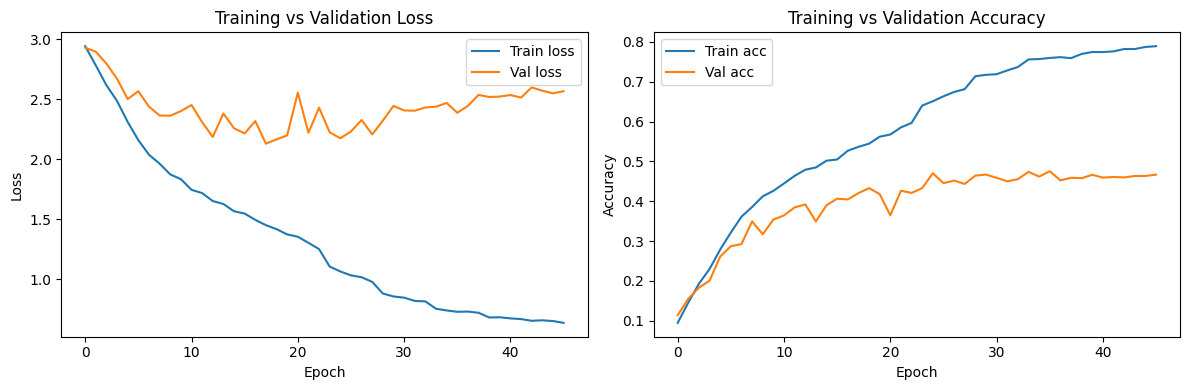

In [9]:
plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history_googlenet.history['loss'], label='Train loss')
plt.plot(history_googlenet.history['val_loss'], label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_googlenet.history['accuracy'], label='Train acc')
plt.plot(history_googlenet.history['val_accuracy'], label='Val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Đánh giá trên tập test

In [10]:
# Dự đoán
y_prob_googlenet = googlenet.predict(test_generator)
y_pred_googlenet = np.argmax(y_prob_googlenet, axis=1)
y_true = test_generator.classes

# Tính các độ đo
acc_googlenet = accuracy_score(y_true, y_pred_googlenet)
precision_googlenet, recall_googlenet, f1_googlenet, _ = precision_recall_fscore_support(
    y_true, y_pred_googlenet, average='macro', zero_division=0
)

# So sánh với LeNet
print(f"\n{'Metric':<20} {'LeNet':<15} {'GoogLeNet':<15} {'Improvement':<15}")
print(f"{'-'*65}")
print(f"{'Accuracy':<20} {0.2336:<15.4f} {acc_googlenet:<15.4f} {(acc_googlenet-0.2336)/0.2336*100:>+.1f}%")
print(f"{'Precision (macro)':<20} {0.3265:<15.4f} {precision_googlenet:<15.4f} {(precision_googlenet-0.3265)/0.3265*100:>+.1f}%")
print(f"{'Recall (macro)':<20} {0.2046:<15.4f} {recall_googlenet:<15.4f} {(recall_googlenet-0.2046)/0.2046*100:>+.1f}%")
print(f"{'F1-score (macro)':<20} {0.1782:<15.4f} {f1_googlenet:<15.4f} {(f1_googlenet-0.1782)/0.1782*100:>+.1f}%")

209/209 [==============================] - 53s 249ms/step

Metric               LeNet           GoogLeNet       Improvement    
-----------------------------------------------------------------
Accuracy             0.2336          0.4367          +86.9%
Precision (macro)    0.3265          0.4682          +43.4%
Recall (macro)       0.2046          0.4168          +103.7%
F1-score (macro)     0.1782          0.4206          +136.0%


Kiểm tra tổng xác suất của lớp Softmax

In [ ]:
# Lấy 3 mẫu
sample_batch, _ = next(test_generator)
test_generator.reset()

# Dự đoán
sample_pred = googlenet.predict(sample_batch[:3], verbose=0)

# Kiểm tra tổng
sums = np.sum(sample_pred, axis=1)
print("Tổng xác suất từng mẫu (phải ≈ 1.0):", sums)
print("Tất cả ≈ 1?", np.allclose(sums, np.ones_like(sums), atol=1e-6))

Báo cáo chi tiết theo từng lớp

In [ ]:
print(classification_report(
    y_true,
    y_pred_googlenet,
    target_names=class_names,
    digits=4
))